In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

##**1. Cargar datos**


In [17]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [18]:
#Datos
tab=pd.read_csv('/drive/My Drive/table_1.csv')


In [ ]:
tab1=tab[(tab['g']<28.5)&(tab['g']>19)&
         (tab['e_g']<0.4)&
         (tab['r']<27)&(tab['r']>18)&
         (tab['e_r']<0.2)&
         (tab['i']>17.5)&
         (tab['e_i']<0.1)&
         (tab['z']<26)&(tab['z']>17)&
         (tab['e_z']<0.2)&
         (tab['y']<25.5)&(tab['y']>17)&
         (tab['e_y']<0.15)&
         (tab['W1']<21.4)&(tab['W1']>17.4)&
         (tab['e_W1']<0.21)&
         (tab['W2']<20.5)&(tab['W2']>17.3)&
         (tab['e_W2']<0.2)&
         (tab['e_z.1']<0.5)&
         (tab['logm']<12)&(tab['logm']>9)]
tab1 = tab1[0:250000]

##**2. Dividir la muestra**

In [ ]:
features=tab1.drop(['z.1','e_z.1','logm','ra', 'dec'], axis=1)
labels=tab1[['z.1','logm']]

In [ ]:
from sklearn.model_selection import train_test_split
#divide todos los datos en muestra de entrenamiento y testeo
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=77)

#divide la muestra de entrenamiento definida anteriormente, en muestra de entrenamiento y de validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=77)

In [ ]:
print(x_train.shape, x_val.shape, x_test.shape)

(140000, 19) (60000, 19) (50000, 19)


In [ ]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=77)

##**3. Definir el modelo y búsqueda de hiperparámetros**

In [ ]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner
import keras


In [ ]:
#Write a function that creates and returns a Keras model. Use the hp argument to define the hyperparameters during model creation.

def build_model(hp):

  #crea el modelo vacio
  model = keras.Sequential()

  #capa de entrada
  model.add(tf.keras.layers.Input(shape=(19,)))

  #capas ocultas (capa densa: capa en la que cada neurona recibe entrada de todas las neuronas de la capa anterior)
  #hiperparametro: número de capas ocultas (1, 2 o 3)
  for i in range(hp.Int("num_layers",
                             min_value=1, #min num de capas ocultas
                             max_value=4, #max num de capas ocultas
                             step=1 )): #tamaño del salto (para obtener 1, 2 3 o 4)


   #hiperparametro número de neuronas por capa
      model.add(tf.keras.layers.Dense(
            units = hp.Int(f'units_{i}',
                           min_value=20, #min num de neuronas por capa
                           max_value=240, #max num de neuronas por capa
                           step=20 ), #tamaño del salto (para obtener 20, 40 ...)

            activation='relu'))

  #capa de salida
  model.add(tf.keras.layers.Dense(units=2, activation='linear'))

  #hiperparametro tasa de aprendizaje del optimizador
  hp_lr = hp.Choice("learning_rate", values=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])

  #elegir el optimizador
  #optimizer_name = hp.Choice('optimizer', ['adam', 'sgd'])
  #optimizer_class = {
   #     'adam': keras.optimizers.Adam,
    #    'sgd': keras.optimizers.SGD}

  #optimizer = optimizer_class[optimizer_name](learning_rate=hp_lr)

  #compilar (optimizador, pérdida, métrica)
  model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_lr),
        #optimizer = optimizer,
        loss = 'mean_absolute_error',
        metrics = ['mean_squared_error'])

  return model


"""model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model"""


  #hp.Choice('units', [8, 16, 32]):
  #Aquí es donde se define un hiperparámetro que determina el número de neuronas (o unidades) en esta capa densa.
  #hp es un objeto que se pasa a la función build_model, generalmente cuando se usa una herramienta de búsqueda de hiperparámetros,
  #como KerasTuner.
  #Choice('units', [8, 16, 32]) indica que el número de neuronas en esta capa densa será elegido entre 8, 16 o 32.
  #Durante la búsqueda de hiperparámetros, diferentes valores serán probados para encontrar cuál es el mejor.
  #"units" es el nombre del hiperparámetro, que se utiliza para identificarlo.
  #[8, 16, 32] es la lista de valores posibles entre los cuales se elegirá el número de neuronas.



"model.add(keras.layers.Dense(\n      hp.Choice('units', [8, 16, 32]),\n      activation='relu'))\n  model.add(keras.layers.Dense(1, activation='relu'))\n  model.compile(loss='mse')\n  return model"

Relación entre Función de Pérdida y Optimizador

- Función de Pérdida:
Proporciona una medida de qué tan bien el modelo está realizando su tarea.
No ajusta directamente los parámetros del modelo, sino que informa al optimizador qué tan grandes son los errores de predicción.
- Optimizador:
Utiliza la información proporcionada por la función de pérdida (a través de los gradientes) para ajustar los pesos y bias del modelo.
En cada iteración del entrenamiento, el optimizador modifica los pesos y bias para reducir la pérdida.

En resumen, la función de pérdida se utiliza para evaluar el rendimiento del modelo y el optimizador se utiliza para ajustar los pesos y bias del modelo basándose en la información proporcionada por la función de pérdida

La *función de pérdida* se utiliza durante el entrenamiento para guiar la
optimización del modelo, mientras que las *métricas de evaluación* se utilizan después del entrenamiento para evaluar el rendimiento del modelo en datos no vistos


In [ ]:
"""#definir el modelo

#crea el modelo vacio
model = tf.keras.Sequential()

#capa de entrada
model.add(tf.keras.layers.Input(shape=(19,)))

#capas ocultas
model.add(tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'))

#capa de salida
model.add(tf.keras.layers.Dense(2, activation='linear'))"""

"#definir el modelo\n\n#crea el modelo vacio\nmodel = tf.keras.Sequential()\n\n#capa de entrada\nmodel.add(tf.keras.layers.Input(shape=(19,)))\n\n#capas ocultas\nmodel.add(tf.keras.layers.Dense(64, activation='relu'),\ntf.keras.layers.Dense(64, activation='relu'))\n\n#capa de salida\nmodel.add(tf.keras.layers.Dense(2, activation='linear'))"

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=2)


In [ ]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_mean_squared_error',
    max_trials=30, #max_trials define cuántos conjuntos diferentes de hiperparámetros se intentarán probar durante el proceso de tuning
    num_initial_points=None,
    overwrite=True) #porque ya hice la búsqueda anterior

In [20]:
#Start the search and get the best model:

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]


In [22]:
#mostrar resultados de la busqueda
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 10 summary
Hyperparameters:
num_layers: 3
units_0: 200
learning_rate: 0.001
units_1: 220
units_2: 140
units_3: 100
Score: 0.00449457298964262

Trial 26 summary
Hyperparameters:
num_layers: 4
units_0: 240
learning_rate: 0.0001
units_1: 240
units_2: 240
units_3: 240
Score: 0.004562038462609053

Trial 14 summary
Hyperparameters:
num_layers: 4
units_0: 120
learning_rate: 0.0001
units_1: 220
units_2: 140
units_3: 160
Score: 0.004898290615528822

Trial 12 summary
Hyperparameters:
num_layers: 2
units_0: 160
learning_rate: 0.0005
units_1: 100
units_2: 20
units_3: 200
Score: 0.005406985059380531

Trial 22 summary
Hyperparameters:
num_layers: 4
units_0: 240
learning_rate: 0.0001
units_1: 20
units_2: 240
units_3: 240
Score: 0.005900795571506023

Trial 01 summary
Hyperparameters:
num_layers: 3
units_0: 160
learning_rate: 0.0001
units_1: 140
units_2: 160
units_3: 100

In [23]:
#establecer el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 220)                 │          44,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 140)                 │          30,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             282 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,442 (310.32 KB)

 Trainable params: 79,442 (310.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#vista detallada de la arquitectura del modelo
#model.summary()

In [ ]:
"""#compilar el modelo

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error', metrics=['mean_squared_error'])
"""

##**4. Entrenamiento y predicción**

In [24]:
#entrenar el modelo
rf = best_model.fit(x_train, y_train, epochs=5, verbose=0)


In [25]:
#predicción
y_pred = best_model.predict(x_test)

#guardarlo
ypred= pd.DataFrame(y_pred)
#ypred.to_csv('ypred.csv', index=False)
ypred = ypred.rename(columns={0: 'z_pred', 1: 'logm_pred'})



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [26]:
print(y_pred)

[[ 1.4088539 10.587389 ]
 [ 0.7039483 10.76667  ]
 [ 1.2112819 11.271828 ]
 ...
 [ 0.9885298 10.671072 ]
 [ 0.1047156 10.479441 ]
 [ 0.9336203 10.807201 ]]


##**5. Evaluación del modelo**

In [27]:
#evaluar el modelo
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f'Pérdida: {loss:.4f}')
print(f'Precisión: {accuracy*100:.2f}%')


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0507 - mean_squared_error: 0.0052
Pérdida: 0.0507
Precisión: 0.52%


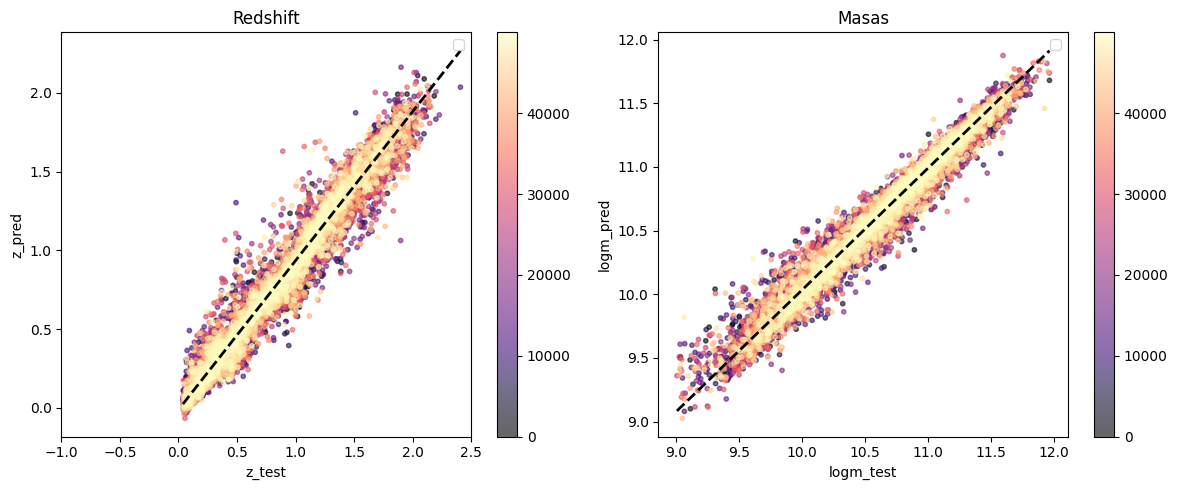

In [28]:
#crear un dataframe con los datos de los valores de la muestra de testeo y los valores predichos
df = pd.DataFrame({'z_test': y_test['z.1'], 'z_pred': y_pred[:, 0], 'logm_test': y_test['logm'], 'logm_pred': y_pred[:, 1]})

#calcular la densidad de puntos para ambos subplots
densidad_puntos_z = np.arange(len(df))
densidad_puntos_logm = np.arange(len(df))

#calcular el mejor ajuste lineal para ambos subplots
#para z
coefficients_z = np.polyfit(df['z_test'], df['z_pred'], 1)
poly_z = np.poly1d(coefficients_z)
x_fit_z = np.linspace(min(df['z_test']), max(df['z_test']), 100)
y_fit_z = poly_z(x_fit_z)

#para logm
coefficients_logm = np.polyfit(df['logm_test'], df['logm_pred'], 1)
poly_logm = np.poly1d(coefficients_logm)
x_fit_logm = np.linspace(min(df['logm_test']), max(df['logm_test']), 100)
y_fit_logm = poly_logm(x_fit_logm)

#distribución de subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#Plot 1 (ajuste de z)
scatter1 = axs[0].scatter(x=df['z_test'], y=df['z_pred'], c=densidad_puntos_z, cmap='magma', s=10, alpha=0.6)
axs[0].plot(x_fit_z, y_fit_z, color='black', linestyle='dashed', linewidth=2)
axs[0].set_xlabel('z_test')
axs[0].set_ylabel('z_pred')
axs[0].set_title('Redshift')
axs[0].legend()
axs[0].set_xlim(-1, 2.5)
cbar1 = plt.colorbar(scatter1, ax=axs[0])

#Plot 2 (ajuste de logm)
scatter2 = axs[1].scatter(x=df['logm_test'], y=df['logm_pred'], c=densidad_puntos_logm, cmap='magma', s=10, alpha=0.6)
axs[1].plot(x_fit_logm, y_fit_logm, color='black', linestyle='dashed', linewidth=2)
axs[1].set_xlabel('logm_test')
axs[1].set_ylabel('logm_pred')
axs[1].set_title('Masas')
axs[1].legend()
cbar2 = plt.colorbar(scatter2, ax=axs[1])

#
plt.tight_layout()

#Mostrar
plt.show()

In [29]:
#valores maximos y minimos
min_z = np.min(y_pred[:, 0])
max_z = np.max(y_pred[:, 0])

min_log_m = np.min(y_pred[:, 1])
max_log_m = np.max(y_pred[:, 1])

print(f"min z: {min_z}, max z: {max_z}")
print(f"min log m: {min_log_m}, max log m: {max_log_m}")

min z: -0.06586036086082458, max z: 2.1620681285858154
min log m: 9.026647567749023, max log m: 11.874813079833984


In [ ]:
#imprimir las keys de rf.history
print(rf.history.keys())


dict_keys(['loss', 'mean_squared_error'])


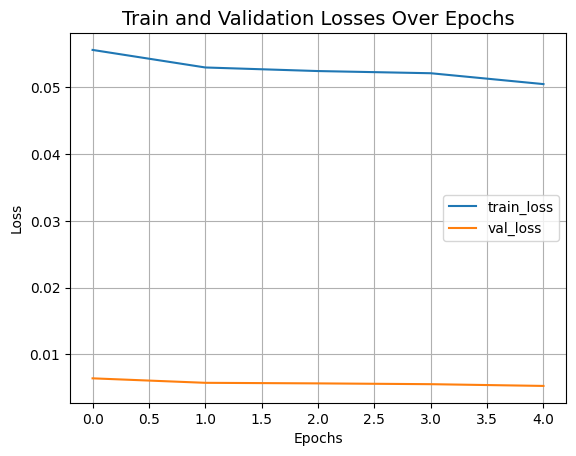

In [30]:
#Let's now visualize the training progress of the model.

plt.plot(rf.history['loss'], label="train_loss")
plt.plot(rf.history['mean_squared_error'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

#"""sirve para visualizar el progreso del entrenamiento del modelo,
#mostrando cómo la pérdida en el conjunto de entrenamiento y validación evoluciona a lo largo de las épocas.


 #   plt.plot(rf.history["loss"], label="train_loss"): grafica la curva de pérdida del conjunto de entrenamiento
  #  (train_loss) a lo largo de las épocas.

   # plt.plot(rf.history["val_loss"], label="val_loss"): grafica la curva de pérdida del conjunto de validación
   # (val_loss) a lo largo de las épocas.

#de este grafico se puede interpretar:

#- Convergencia: si las curvas de train_loss y val_loss convergen, indica que el modelo está aprendiendo bien.
#- Overfitting: si train_loss sigue disminuyendo mientras que val_loss se estabiliza o aumenta
#- Underfitting: si tanto train_loss como val_loss son altos y no disminuyen mucho, podría ser una señal de que el modelo no está aprendiendo bien (underfitting).

